# Data Analysis

<p>This file is use to analyse the data files generated using the OpenStuido software as a part of DMX9213 research. The below steps will be followed for the data analysis.</p>

- Step 1: Open .csv file and preprocess the data.
- Step 2: Calculate the PMV values for each hour.
- Step 3: Identify the month with highest cumilative PMV values averaged over 30 days from the baselins.
- Step 4: Check if the months are different from each baselines. If different, use the month that selected by majority of models.
- Step 5: Average the temperature, humidity and PMV values for the selected month. Average values should represent 24 hour variation of temperature and humidity for the selected month.
- Step 6: Generate graphs to compair the temperature, humidity and PMV values for the baseline and the passive cooling implimented models. The comparison should be performend for the selected month.


### General

This section will be used to import the data necessary for all simulation.

In [49]:
%%time 

# install packages
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


CPU times: total: 31.2 ms
Wall time: 12.6 s

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/2e/51/c77a14869b7eb9d6fb440e811b754fc3950d6868c38ace57d0632b674415/matplotlib-3.8.2-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/8e/ae/a6353db548bff1a592b85ae6bb80275f0a51dc25a0410d059e5b33183e36/contourpy-1.2.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/81/4b/42d0488765ea5aa308b4e8197cb75366b2124240a73e86f98b6107ccf282/fonttools-4.47.2-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/160.8 kB ? eta -:--:--
     -- ----------------


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [89]:
# import packages
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
# paths
BASELINE_PATH = "input/baseline/"
IMPROVED_PATH = "input/improved/"
baseline_csv_files = os.listdir(BASELINE_PATH)
improved_csv_files = os.listdir(IMPROVED_PATH)

In [4]:
# import the test file
TEST_FILE_PATH = "input/test.csv"

In [5]:
# parameter to run the test cells
run_test = True

### Step 1


Open .csv file and preprocess the data.

In [6]:
def preprocess_data(file_path: str) -> pd.DataFrame:

    df = pd.read_csv(file_path)

    # remove columns relevent to plenum space
    columns_to_drop = [column_name for column_name in df.columns if "PLENUM" in column_name]
    df.drop(columns=columns_to_drop, inplace=True)

    # rename the columns
    for column_name in df.columns:
        df.rename(columns={column_name: column_name.replace('LIVINGTHERMALZONE:Zone', '').strip()}, inplace=True)

    # change the hourly column to datetime
    df["Hourly"] = pd.to_datetime(df["Hourly"])

    return df

In [7]:
if run_test:
    step_1_test_df = preprocess_data(TEST_FILE_PATH)
    display(step_1_test_df.head())

,Hourly,Air Relative Humidity[%],Air Temperature[C],Mean Radiant Temperature[C],Outdoor Air Drybulb Temperature[C],Outdoor Air Wetbulb Temperature[C]
0,2006-01-01 01:00:00,79.261238,27.116869,27.077136,24.642456,23.291442
1,2006-01-01 02:00:00,82.436045,26.616540,26.633980,23.984123,23.241227
2,2006-01-01 03:00:00,84.435859,26.223098,26.240367,23.842456,23.174662
3,2006-01-01 04:00:00,86.096696,25.895915,25.903493,23.742456,23.127976
4,2006-01-01 05:00:00,87.458615,25.580347,25.581124,23.584123,23.043825


### Step 2

Calculate PMV values for each hour. \
Refer to following link for more details on PMV calculation. \
https://github.com/chathusha/PmvCalculator

In [8]:
def calculate_clo(m: float, icl: float) -> float:
    """
    Calculates the clo for a given metabolic rate and clothing insulation using ASHRAE 55:2023.
    
    Args:
        m (float): metabolic rate in met unit
        icl (float): clothing insulation in clo unit
    
    Return:
        float: clo value to use in the PMV calculator
    """
    if m < 1.2:
        clo = icl

    else:
        clo = icl * (0.6 + 0.4 / m)

    return clo

In [9]:
def calculate_pmv(ta: float, tr: float, vel: float, rh: float, met: float, clo: float, wme: float) -> dict:
    """
     Calculate the PMV for given inputs using ASHRAE 55:2023. The air speed shouldn't be above 0.1 m/s.

     Args:
          ta (float): air temperature in C
          tr (float): mean radiant temperature in C
          vel(float): air speed in m/s
          rh (float): relative humidity in %
          met (float): metabolic rate in met unit
          clo (float): clothing factor in clo unit (calculated using calculate_clo method)
          wme (float): external work in met

     Return:
          dict: {
               pmv: Predicted Mean Vote (PMV),
               ppd: Predicted Precentage of Dissatisfied (PPD),
               status: status of the calculation, 0 succeed, 1 error
               }
     """
    if met > 1:
        pa = rh * 10. * math.exp(16.6536 - 4030.183 / (ta + 235.))
        icl = 0.155 * clo  # thermal insulation of the clothing in m2K/W
        m = met * 58.15  # metabolic rate in W/m2
        w = wme * 58.15  # extenal work in W/m2
        mw = m - w  # internal heat production in the humen body

        if icl <= 0.078:
            fcl = 1 + (1.29 * icl)
        else:
            fcl = 1.05 + (0.645 * icl)

        # heat transfer coefficient by forced convection
        hcf = 12.1 * math.sqrt(vel)
        taa = ta + 273.
        tra = tr + 273.
        tcla = taa + (35.5 - ta) / (3.5 * icl + 0.1)
        p1 = icl * fcl
        p2 = p1 * 3.96
        p3 = p1 * 100.
        p4 = p1 * taa
        p5 = 308.7 - 0.028 * mw + (p2 * math.pow(tra / 100, 4))
        xn = tcla / 100.
        xf = tcla / 50.
        eps = 0.00015
        n = 0

        while abs(xn - xf) > eps:
            xf = (xf + xn) / 2
            hcn = 2.38 * math.pow(abs(100. * xf - taa), 0.25)
            hc = hcf if hcf > hcn else hcn
            xn = (p5 + p4 * hc - p2 * math.pow(xf, 4)) / (100. + p3 * hc)
            n += 1
            if n > 150:
                print("Max iterations exceeded")
                return {
                    'pmv': 0,
                    'ppd': 0,
                    'status': 1
                    }

        tcl = 100. * xn - 273.

        # heat loss diff. through skin
        hl1 = 3.05 * 0.001 * (5733 - (6.99 * mw) - pa)

        # heat loss by sweating
        hl2 = 0.42 * (mw - 58.15) if (mw > 58.15) else 0

        # latent respiration heat loss
        hl3 = 1.7 * 0.00001 * m * (5867. - pa)

        # dry respiration heat loss
        hl4 = 0.0014 * m * (34. - ta)

        # heat loss by radiation
        hl5 = 3.96 * fcl * (math.pow(xn, 4) - math.pow(tra / 100., 4))

        # heat loss by convection
        hl6 = fcl * hc * (tcl - ta)

        ts = 0.303 * math.exp(-0.036 * m) + 0.028
        pmv = ts * (mw - hl1 - hl2 - hl3 - hl4 - hl5 - hl6)
        ppd = 100 - 95 * \
        math.exp(-0.03353 * math.pow(pmv, 4) - 0.2179 * math.pow(pmv, 2))

        return {
            'pmv': pmv,
            'ppd': ppd,
            'status': 0
            }

    else:
        print("ASHRAE 55:2023 calculation does not available for metabolic rate less than 1")
        return {
            'pmv': 0,
            'ppd': 0,
            'status': 1
            }

In [10]:
def add_pmv_column(df: pd.DataFrame) -> pd.DataFrame:

    df['PMV'] = df.apply(lambda x: calculate_pmv(
        ta=x['Air Temperature[C]'],
        tr=x['Mean Radiant Temperature[C]'],
        vel=0.1,
        rh=x['Air Relative Humidity[%]'],
        met=1.2,
        clo=calculate_clo(m=1.2, icl=0.36),
        wme=0
        )['pmv'], axis=1)

    return df

In [11]:
if run_test:
    step_2_test_df = add_pmv_column(step_1_test_df)
    display(step_2_test_df.head())

,Hourly,Air Relative Humidity[%],Air Temperature[C],Mean Radiant Temperature[C],Outdoor Air Drybulb Temperature[C],Outdoor Air Wetbulb Temperature[C],PMV
0,2006-01-01 01:00:00,79.261238,27.116869,27.077136,24.642456,23.291442,0.701558
1,2006-01-01 02:00:00,82.436045,26.616540,26.633980,23.984123,23.241227,0.559119
2,2006-01-01 03:00:00,84.435859,26.223098,26.240367,23.842456,23.174662,0.435502
3,2006-01-01 04:00:00,86.096696,25.895915,25.903493,23.742456,23.127976,0.331001
4,2006-01-01 05:00:00,87.458615,25.580347,25.581124,23.584123,23.043825,0.228766


### Step 3

Calculate the average pmv value for each month. \
Identify the month with highest cumilative PMV values averaged over 30 days from the baseline.

In [12]:
def get_month_with_highest_cum_pmv(df: pd.DataFrame) -> int:

    # calculate the mean pmv for day of each month
    group_by_month = df.groupby(df["Hourly"].dt.month)["PMV"].mean()*24

    # multiply the value by 30 to get monthly avearage
    group_by_month = group_by_month * 30

    max_cum_pmv_month = group_by_month.index[group_by_month == group_by_month.max()][0]
    
    return max_cum_pmv_month

In [13]:
if run_test:
    step_3_test = get_month_with_highest_cum_pmv(step_2_test_df)
    display(step_3_test)

4

### Step 4

Calculate the PMV value for all building models in the baseline.\
Check if the month with highest cumilative PMV values averaged over 30 days from the baseline is different from each baselines.

In [14]:
months_with_highest_pmv = {}
baseline_dfs = {}

for baseline_csv_file in baseline_csv_files[:4 if run_test else len(baseline_csv_files)]:
    preprocessed_baseline_df = preprocess_data(os.path.join(BASELINE_PATH, baseline_csv_file))
    baseline_df = add_pmv_column(preprocessed_baseline_df)
    max_month_with_cum_pmv = get_month_with_highest_cum_pmv(baseline_df)
    months_with_highest_pmv[baseline_csv_file] = max_month_with_cum_pmv

    # store baseline files
    baseline_dfs[baseline_csv_file.strip(".csv")] = baseline_df

months_with_highest_cum_pmv_df = pd.DataFrame(
    months_with_highest_pmv.items(),
    columns=['File Name', 'Month with Highest Cumulative PMV']
)

display(months_with_highest_cum_pmv_df)


,File Name,Month with Highest Cumulative PMV
0,10deg_roof_without_ceiling_0deg_no_roof_paint.csv,4
1,10deg_roof_without_ceiling_180deg_no_roof_pain...,4
2,10deg_roof_without_ceiling_270deg_no_roof_pain...,4
3,10deg_roof_without_ceiling_90deg_no_roof_paint...,4


In [15]:
# get the most common month from above data
month_with_highest_cum_pmv = months_with_highest_cum_pmv_df['Month with Highest Cumulative PMV'].mode()[0]
print(f"Most common month with highest cumulative PMV: {month_with_highest_cum_pmv}")

Most common month with highest cumulative PMV: 4


### Step 5

Calculate the hourly averaged temperature, humidity and PMV values for the selected month using baseline data.

In [67]:
highest_cum_pmv_month_dfs = {}

for key, baseline_df in baseline_dfs.items():
    df = baseline_df.loc[baseline_df["Hourly"].dt.month == month_with_highest_cum_pmv]

    # create columns for month and hour
    highest_cum_pmv_month_df = df.copy()
    highest_cum_pmv_month_df["Month"] = df["Hourly"].dt.month.astype(int)
    highest_cum_pmv_month_df["Hour"] = df["Hourly"].dt.hour.astype(int)
    

    # drop hourly column
    highest_cum_pmv_month_df.drop(columns=["Hourly"], inplace=True)
    
    # calculate the hourly averaged the temperature, humidity and PMV
    highest_cum_pmv_month_df = highest_cum_pmv_month_df.groupby(highest_cum_pmv_month_df["Hour"]).mean()
    highest_cum_pmv_month_df.reset_index(inplace=True)

    highest_cum_pmv_month_dfs[key] = highest_cum_pmv_month_df

In [68]:
if run_test:
    display(highest_cum_pmv_month_dfs[list(highest_cum_pmv_month_dfs.keys())[0]])

,Hour,Air Relative Humidity[%],Air Temperature[C],Mean Radiant Temperature[C],Outdoor Air Drybulb Temperature[C],Outdoor Air Wetbulb Temperature[C],PMV,Month
0,0,80.405314,28.498136,28.559809,27.160640,25.004634,1.219037,4.0
1,1,82.137005,28.085822,28.162846,26.757029,24.833473,1.088658,4.0
2,2,83.513702,27.678724,27.767978,26.388695,24.643067,0.956694,4.0
3,3,84.831838,27.277346,27.378361,26.034529,24.467220,0.826387,4.0
4,4,85.970274,26.903690,27.006962,25.742862,24.265257,0.702999,4.0
5,5,86.827936,26.558548,26.655340,25.504529,24.065717,0.586082,4.0
6,6,87.584334,26.232420,26.318828,25.290084,23.890729,0.474378,4.0
7,7,87.800551,26.102570,26.231797,25.780917,24.117070,0.436778,4.0
8,8,82.271373,27.371490,27.858467,26.773417,24.619749,0.903193,4.0
9,9,72.053476,29.980035,30.798476,27.764251,25.122146,1.805619,4.0


### Step 6

Convert the improved csv files to processed dataframes.\
Generate graphs to compair the temperature, humidity and PMV values for the baseline and the passive cooling implimented models.

In [70]:
for improved_csv_file in improved_csv_files[0:4 if run_test else len(improved_csv_files)]:
    preprocessed_improved_df = preprocess_data(os.path.join(IMPROVED_PATH, improved_csv_file))
    improved_df = add_pmv_column(preprocessed_improved_df)

    # seperate data only relevent to selected month
    df = improved_df.loc[improved_df["Hourly"].dt.month == month_with_highest_cum_pmv]

    # create columns for month and hour
    highest_cum_pmv_month_df = df.copy()
    highest_cum_pmv_month_df["Month"] = df["Hourly"].dt.month.astype(int)
    highest_cum_pmv_month_df["Hour"] = df["Hourly"].dt.hour.astype(int)

    # drop hourly column
    highest_cum_pmv_month_df.drop(columns=["Hourly"], inplace=True)

    # calculate the hourly averaged the temperature, humidity and PMV
    highest_cum_pmv_month_df = highest_cum_pmv_month_df.groupby(highest_cum_pmv_month_df["Hour"]).mean()
    highest_cum_pmv_month_df.reset_index(inplace=True)

    highest_cum_pmv_month_dfs[improved_csv_file.strip(".csv")] = highest_cum_pmv_month_df
    

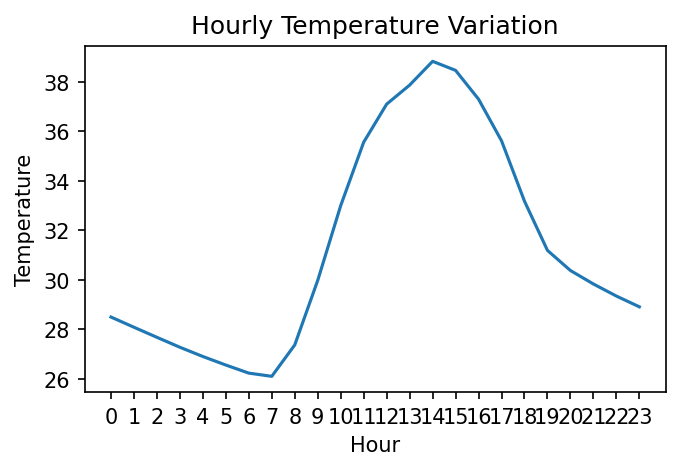

In [93]:
if run_test:
    df = highest_cum_pmv_month_dfs[list(highest_cum_pmv_month_dfs.keys())[0]]
    plt.figure(figsize=(5, 3), dpi=150)
    plt.plot('Hour', 'Air Temperature[C]', data=df)
    plt.title('Hourly Temperature Variation')
    plt.xlabel('Hour')
    plt.ylabel('Temperature')

    plt.xticks(np.arange(min(df['Hour']), max(df['Hour'])+1, 1))
    plt.show()